<a href="https://colab.research.google.com/github/benvictoria21/MachineLearning/blob/master/Heart_disease_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,KFold,cross_val_score,KFold
from collections import Counter
import os
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score 
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [71]:
data = pd.read_csv("https://raw.githubusercontent.com/benvictoria21/pandas/master/dataset/Heart%20Disease%20Dataset.csv")

In [72]:
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [73]:
data["target"].value_counts()

1    165
0    138
Name: target, dtype: int64

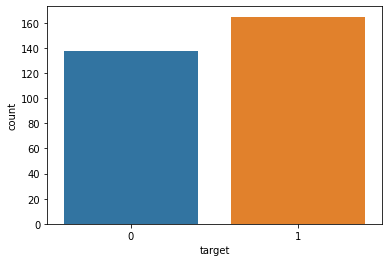

In [74]:
sns.countplot(x="target",data=data)

In [75]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [76]:
data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [77]:
data.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5]), <a list of 14 Text major ticklabel objects>)

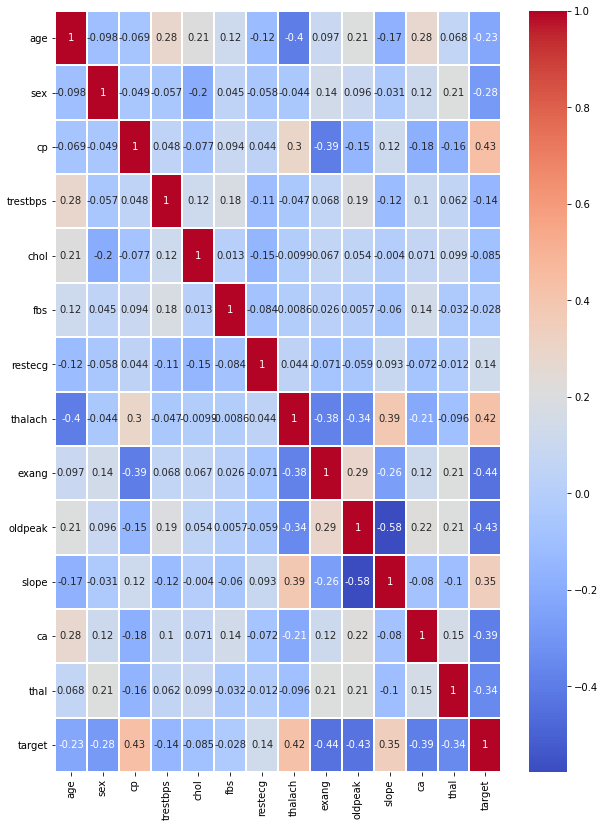

In [78]:
fig,ax = plt.subplots(figsize=(10,14))
ax = sns.heatmap(data.corr(),cmap='coolwarm',linecolor='white',linewidths=1,annot=True)
plt.yticks(rotation=0) 

In [79]:
data.groupby("slope")["target"].sum()

slope
0      9
1     49
2    107
Name: target, dtype: int64

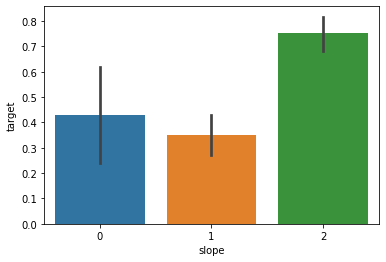

In [80]:
sns.barplot(x="slope", y="target", data=data)

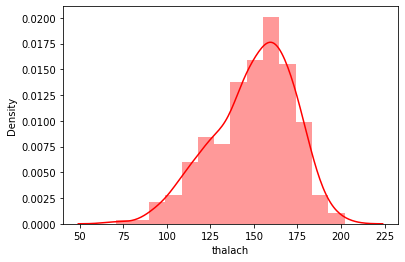

In [81]:
sns.distplot(data['thalach'],color='red')

In [82]:
data.groupby("cp")["target"].sum()

cp
0    39
1    41
2    69
3    16
Name: target, dtype: int64

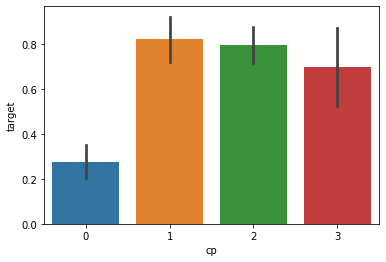

In [83]:
sns.barplot(x='cp',y='target',data=data)

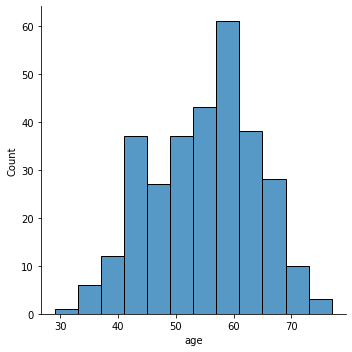

In [84]:
sns.displot(data["age"])

In [85]:
def get_outliers(df,n,features):
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1

        # outlier step
        outlier_step = 1.5 * IQR

        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index

        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)

    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )

    return multiple_outliers   
# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = get_outliers(data,2,["age","chol","restecg","trestbps","oldpeak"])

In [86]:
data.loc[Outliers_to_drop]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target


In [87]:
data.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

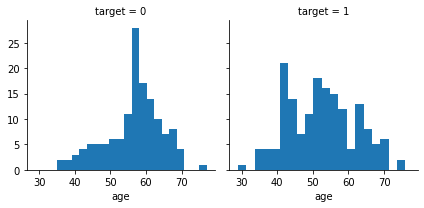

In [88]:
g= sns.FacetGrid(data,col='target')
g.map(plt.hist,'age',bins=20)

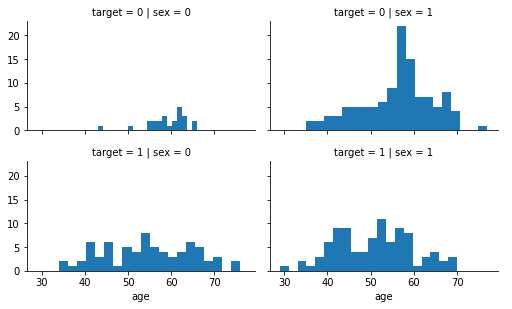

In [89]:
grid = sns.FacetGrid(data, row='target', col='sex', size=2.2, aspect=1.6)
grid.map(plt.hist, 'age',  bins=20)
grid.add_legend()

In [90]:
data['AgeBand'] = pd.cut(data['age'], 5)
data[['AgeBand', 'target']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,target
0,"(28.952, 38.6]",0.750000
1,"(38.6, 48.2]",0.704225
2,"(48.2, 57.8]",0.577320
3,"(57.8, 67.4]",0.377358
4,"(67.4, 77.0]",0.588235


In [91]:
data.loc[ data['age'] < 38.6, 'age_group'] = 1
data.loc[(data['age'] >= 38.6) & (data['age'] < 48.2), 'age_group'] = 2
data.loc[(data['age'] >= 48.2) & (data['age'] < 57.8), 'age_group'] = 3
data.loc[(data['age'] >= 57.8) & (data['age'] < 67.4), 'age_group'] = 4
data.loc[ data['age'] >= 67.4, 'age_group'] = 5
data['age_group'].astype('int')
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,AgeBand,age_group
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1,"(57.8, 67.4]",4.0
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1,"(28.952, 38.6]",1.0
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1,"(38.6, 48.2]",2.0
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1,"(48.2, 57.8]",3.0
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1,"(48.2, 57.8]",3.0


In [92]:
data.drop(['age','AgeBand'] , axis= 1,inplace=True)

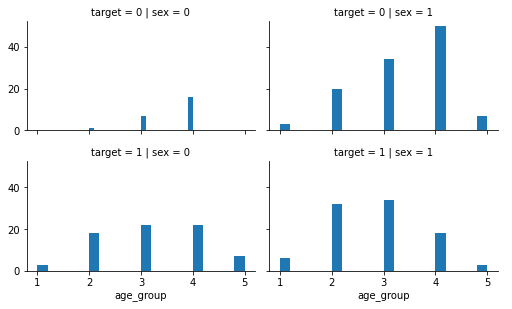

In [93]:
grid = sns.FacetGrid(data, row='target', col='sex', size=2.2, aspect=1.6)
grid.map(plt.hist, 'age_group',  bins=20)
grid.add_legend()

In [94]:
data = pd.get_dummies(data, columns=["age_group"], prefix="AgeGrp")
data.head()

,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,AgeGrp_1.0,AgeGrp_2.0,AgeGrp_3.0,AgeGrp_4.0,AgeGrp_5.0
0,1,3,145,233,1,0,150,0,2.3,0,0,1,1,0,0,0,1,0
1,1,2,130,250,0,1,187,0,3.5,0,0,2,1,1,0,0,0,0
2,0,1,130,204,0,0,172,0,1.4,2,0,2,1,0,1,0,0,0
3,1,1,120,236,0,1,178,0,0.8,2,0,2,1,0,0,1,0,0
4,0,0,120,354,0,1,163,1,0.6,2,0,2,1,0,0,1,0,0


In [95]:
data.groupby('sex')['target'].count()

sex
0     96
1    207
Name: target, dtype: int64

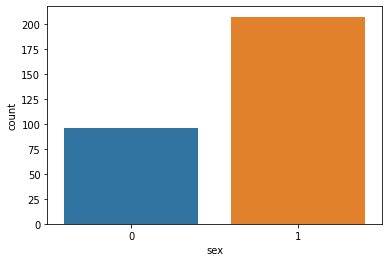

In [96]:
sns.countplot(data=data,x="sex")

In [97]:
data = pd.get_dummies(data,columns = ['sex'], prefix="Sex")


In [98]:
data = pd.get_dummies(data,columns = ['cp'], prefix="CP")
data.head()

,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,AgeGrp_1.0,AgeGrp_2.0,AgeGrp_3.0,AgeGrp_4.0,AgeGrp_5.0,Sex_0,Sex_1,CP_0,CP_1,CP_2,CP_3
0,145,233,1,0,150,0,2.3,0,0,1,1,0,0,0,1,0,0,1,0,0,0,1
1,130,250,0,1,187,0,3.5,0,0,2,1,1,0,0,0,0,0,1,0,0,1,0
2,130,204,0,0,172,0,1.4,2,0,2,1,0,1,0,0,0,1,0,0,1,0,0
3,120,236,0,1,178,0,0.8,2,0,2,1,0,0,1,0,0,0,1,0,1,0,0
4,120,354,0,1,163,1,0.6,2,0,2,1,0,0,1,0,0,1,0,1,0,0,0


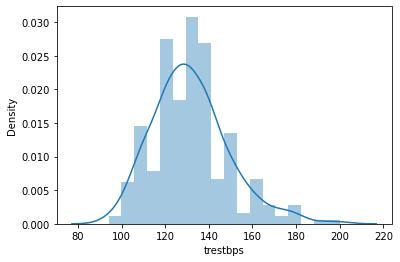

In [99]:
sns.distplot(data['trestbps'])

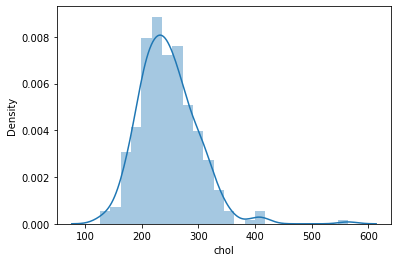

In [100]:
sns.distplot(data['chol'])

In [102]:
data['chol'].skew()

1.1434008206693387

In [105]:
data['fbs'].value_counts() /data.shape[0] * 100

0    85.148515
1    14.851485
Name: fbs, dtype: float64

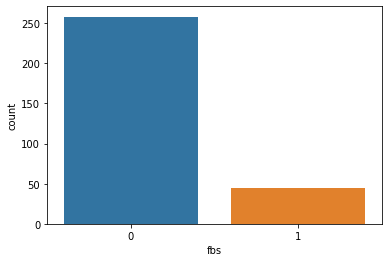

In [106]:
sns.countplot(data['fbs'])

In [107]:
data = pd.get_dummies(data,columns=['fbs'],prefix='fbs')
data.head()

,trestbps,chol,restecg,thalach,exang,oldpeak,slope,ca,thal,target,AgeGrp_1.0,AgeGrp_2.0,AgeGrp_3.0,AgeGrp_4.0,AgeGrp_5.0,Sex_0,Sex_1,CP_0,CP_1,CP_2,CP_3,fbs_0,fbs_1
0,145,233,0,150,0,2.3,0,0,1,1,0,0,0,1,0,0,1,0,0,0,1,0,1
1,130,250,1,187,0,3.5,0,0,2,1,1,0,0,0,0,0,1,0,0,1,0,1,0
2,130,204,0,172,0,1.4,2,0,2,1,0,1,0,0,0,1,0,0,1,0,0,1,0
3,120,236,1,178,0,0.8,2,0,2,1,0,0,1,0,0,0,1,0,1,0,0,1,0
4,120,354,1,163,1,0.6,2,0,2,1,0,0,1,0,0,1,0,1,0,0,0,1,0


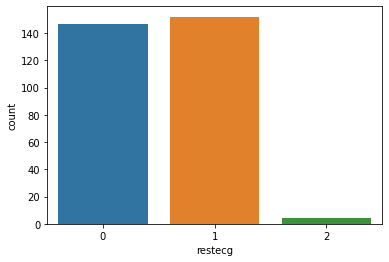

In [108]:
sns.countplot(data['restecg'])

In [109]:
data = pd.get_dummies(data,columns=['restecg'],prefix='restecg')
data.head()

,trestbps,chol,thalach,exang,oldpeak,slope,ca,thal,target,AgeGrp_1.0,AgeGrp_2.0,AgeGrp_3.0,AgeGrp_4.0,AgeGrp_5.0,Sex_0,Sex_1,CP_0,CP_1,CP_2,CP_3,fbs_0,fbs_1,restecg_0,restecg_1,restecg_2
0,145,233,150,0,2.3,0,0,1,1,0,0,0,1,0,0,1,0,0,0,1,0,1,1,0,0
1,130,250,187,0,3.5,0,0,2,1,1,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0
2,130,204,172,0,1.4,2,0,2,1,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0
3,120,236,178,0,0.8,2,0,2,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0
4,120,354,163,1,0.6,2,0,2,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0


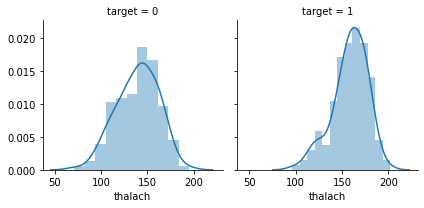

In [110]:
g= sns.FacetGrid(data,col='target')
g.map(sns.distplot,'thalach')

In [111]:
data['exang'].value_counts()

0    204
1     99
Name: exang, dtype: int64

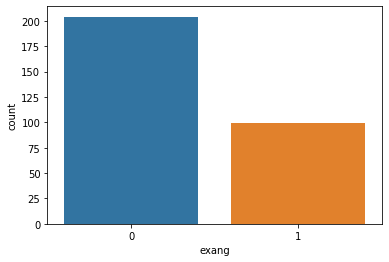

In [112]:
sns.countplot(data['exang'])

In [113]:
data = pd.get_dummies(data,columns=['exang'],prefix='exang')

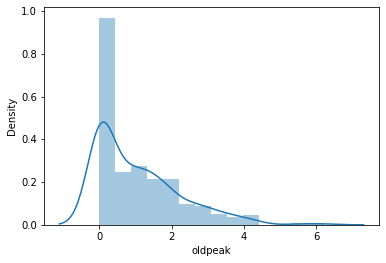

In [114]:
sns.distplot(data['oldpeak'])

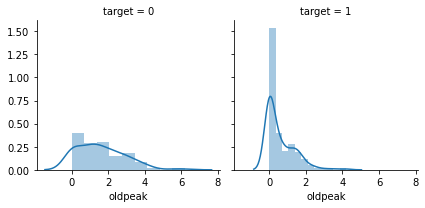

In [115]:
g= sns.FacetGrid(data,col='target')
g.map(sns.distplot,'oldpeak')

In [116]:
data = pd.get_dummies(data,columns=['slope'],prefix='slope')

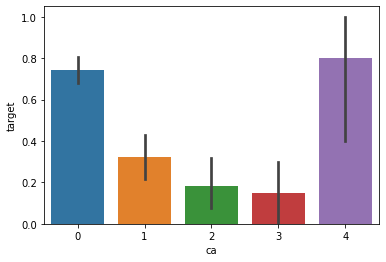

In [117]:
sns.barplot(x='ca',y='target',data=data)

In [118]:
data = pd.get_dummies(data,columns=['ca'],prefix='ca')

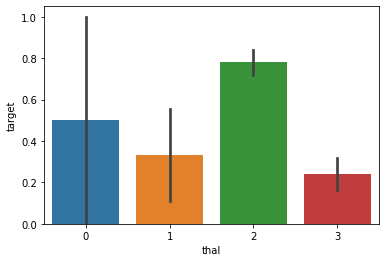

In [119]:
sns.barplot(x='thal',y='target',data=data)

In [120]:
data = pd.get_dummies(data,columns=['thal'],prefix='thal')

In [121]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 35 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   trestbps    303 non-null    int64  
 1   chol        303 non-null    int64  
 2   thalach     303 non-null    int64  
 3   oldpeak     303 non-null    float64
 4   target      303 non-null    int64  
 5   AgeGrp_1.0  303 non-null    uint8  
 6   AgeGrp_2.0  303 non-null    uint8  
 7   AgeGrp_3.0  303 non-null    uint8  
 8   AgeGrp_4.0  303 non-null    uint8  
 9   AgeGrp_5.0  303 non-null    uint8  
 10  Sex_0       303 non-null    uint8  
 11  Sex_1       303 non-null    uint8  
 12  CP_0        303 non-null    uint8  
 13  CP_1        303 non-null    uint8  
 14  CP_2        303 non-null    uint8  
 15  CP_3        303 non-null    uint8  
 16  fbs_0       303 non-null    uint8  
 17  fbs_1       303 non-null    uint8  
 18  restecg_0   303 non-null    uint8  
 19  restecg_1   303 non-null    u

In [122]:
target = data['target']
data.drop('target',axis=1,inplace=True)

In [123]:
numeric_feats = data.dtypes[data.dtypes != "uint8" ].index
numeric_feats

Index(['trestbps', 'chol', 'thalach', 'oldpeak'], dtype='object')

In [124]:
ss= StandardScaler()
data[numeric_feats] = ss.fit_transform(data[numeric_feats])

In [125]:
data.head()

,trestbps,chol,thalach,oldpeak,AgeGrp_1.0,AgeGrp_2.0,AgeGrp_3.0,AgeGrp_4.0,AgeGrp_5.0,Sex_0,Sex_1,CP_0,CP_1,CP_2,CP_3,fbs_0,fbs_1,restecg_0,restecg_1,restecg_2,exang_0,exang_1,slope_0,slope_1,slope_2,ca_0,ca_1,ca_2,ca_3,ca_4,thal_0,thal_1,thal_2,thal_3
0,0.763956,-0.256334,0.015443,1.087338,0,0,0,1,0,0,1,0,0,0,1,0,1,1,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0
1,-0.092738,0.072199,1.633471,2.122573,1,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0
2,-0.092738,-0.816773,0.977514,0.310912,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0
3,-0.663867,-0.198357,1.239897,-0.206705,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0
4,-0.663867,2.082050,0.583939,-0.379244,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0


In [126]:
x_train,x_test,y_train,y_test = train_test_split(data.values , target.values ,train_size = 0.75)

In [127]:
print(f'{x_train.shape}  {y_train.shape} {x_test.shape} {y_test.shape}')

(227, 34)  (227,) (76, 34) (76,)


In [128]:
def run_cv_model(classifier,x,y,**params):
    clf = classifier(**params)
    
    scores = cross_val_score(clf,x,y,cv=5)

    return round(scores.mean() * 100,2)

In [129]:
gb_score = run_cv_model(GradientBoostingClassifier,x_train,y_train ,learning_rate = 0.1,n_estimators =500)
gb_score

78.41

In [130]:
gb_score_1 =  run_cv_model(GradientBoostingClassifier,x_train,y_train ,learning_rate = 0.5,n_estimators= 500)
gb_score_1

80.15

In [131]:
gb_score_2 =  run_cv_model(GradientBoostingClassifier,x_train,y_train ,learning_rate  = 0.1,n_estimators = 200)
gb_score_2

78.4

In [132]:
rf_score_1 = run_cv_model(RandomForestClassifier,x_train,y_train , n_estimators = 500 ,criterion ='gini',max_depth =1)
rf_score_1

81.05

In [133]:
rf_score_2 = run_cv_model(RandomForestClassifier,x_train,y_train , n_estimators =500 ,criterion ='entropy',max_depth =1)
rf_score_2

80.18

In [134]:
rf_score_3 = run_cv_model(RandomForestClassifier,x_train,y_train , n_estimators =1000 ,criterion = 'entropy',max_depth =1)
rf_score_3

79.75

In [135]:
rf_score_4 = run_cv_model(RandomForestClassifier,x_train,y_train , n_estimators = 1000 ,criterion = 'gini',max_depth =1)
rf_score_4

80.63

In [136]:
ab_score_1 = run_cv_model(AdaBoostClassifier,x_train,y_train , n_estimators = 100,learning_rate=1)
ab_score_1                         

78.85

In [137]:
ab_score_2 = run_cv_model(AdaBoostClassifier,x_train,y_train , n_estimators =1000,learning_rate=1)
ab_score_2 

76.65

In [138]:
ab_score_3 = run_cv_model(AdaBoostClassifier,x_train,y_train , n_estimators =100,learning_rate =0.1)
ab_score_3   

81.09

In [139]:
ab_score_4 = run_cv_model(AdaBoostClassifier,x_train,y_train , n_estimators = 1000,learning_rate= 0.1)
ab_score_4   

82.4

In [140]:
svm_score_1 = run_cv_model(SVC,x_train,y_train , C =1,kernel ='rbf')
svm_score_1   

82.37

In [141]:
svm_score_2 = run_cv_model(SVC,x_train,y_train , C =0.1,kernel ='rbf')
svm_score_2 

81.5

In [142]:
svm_score_3 = run_cv_model(SVC,x_train,y_train , C = 1,kernel = 'linear')
svm_score_3

83.69

In [143]:
svm_score_4 = run_cv_model(SVC,x_train,y_train , C= 0.1,kernel='linear')
svm_score_4

84.14

In [144]:
svm_score_5 = run_cv_model(SVC,x_train,y_train , C =1,kernel ='poly')
svm_score_5

82.41

In [145]:
svm_score_6 = run_cv_model(SVC,x_train,y_train , C = 0.1,kernel='poly')
svm_score_6

78.86

In [146]:
models_names = ['Gradient boosting','Gradient boosting','Gradient boosting','Random forest','Random forest',
                'Random forest','Random forest','Adaboost','Adaboost','Adaboost','Adaboost',
               'SVM','SVM','SVM','SVM','SVM','SVM']
models_scores =[gb_score , gb_score_1,gb_score_2,rf_score_1,rf_score_2,rf_score_3,rf_score_4,
               ab_score_1,ab_score_2,ab_score_3,ab_score_4,svm_score_1,svm_score_2,svm_score_3,svm_score_4,svm_score_5,svm_score_6]
cross_validation_df = pd.DataFrame({'Model' :models_names,'Score' :models_scores})
cross_validation_df

,Model,Score
0,Gradient boosting,78.41
1,Gradient boosting,80.15
2,Gradient boosting,78.40
3,Random forest,81.05
4,Random forest,80.18
5,Random forest,79.75
6,Random forest,80.63
7,Adaboost,78.85
8,Adaboost,76.65
9,Adaboost,81.09


In [147]:
cross_validation_df.groupby('Model').max()

,Score
Model,
Adaboost,82.40
Gradient boosting,80.15
Random forest,81.05
SVM,84.14


In [148]:
def get_oof(classifier, x_train, y_train, x_test,n_folds,**params):
    oof_train = np.zeros(x_train.shape[0])
    oof_test = np.zeros(x_test.shape[0])
    oof_test_skf = np.empty((n_folds, len(y_test)))
   
    clf = classifier(**params) 
    kf = KFold(n_splits=n_folds) 
    for i, (train_index, valid_index) in enumerate(kf.split(x_train,y_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_valid = x_train[valid_index]

        clf.fit(x_tr, y_tr)

        oof_train[valid_index] = clf.predict(x_valid)
        oof_test_skf[i, :] = clf.predict(x_test)

    
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)
#start stacking
gd_oof_train , gd_oof_test =  get_oof(GradientBoostingClassifier,x_train,y_train ,x_test , 5,learning_rate  = 0.1,n_estimators = 200)
rf_oof_train , rf_oof_test =  get_oof(RandomForestClassifier,x_train,y_train ,x_test,5, n_estimators =500 ,criterion ='entropy',max_depth =1)
ad_oof_train , ad_oof_test =  get_oof(AdaBoostClassifier,x_train,y_train ,x_test,5, n_estimators = 1000,learning_rate= 0.1)
svm_oof_train,svm_oof_test =  get_oof(SVC,x_train,y_train ,x_test,5, C= 0.1,kernel='linear')
#construct new training set from stacking
x_stacking_train = pd.DataFrame({'Gradient boosting':gd_oof_train.flatten() , 'Random forest': rf_oof_train.flatten(),
                                'Adaboost' : ad_oof_train.flatten() , 'SVM':svm_oof_train.flatten()})

x_stacking_train.head()

,Gradient boosting,Random forest,Adaboost,SVM
0,0.0,1.0,0.0,0.0
1,1.0,1.0,0.0,1.0
2,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0


In [149]:
x_stacking_test =np.c_[gd_oof_test,rf_oof_test]
x_stacking_test = np.c_[x_stacking_test,ad_oof_test]
x_stacking_test = np.c_[x_stacking_test,svm_oof_test]

In [150]:
x_stacking_test.shape

(76, 4)

In [151]:
xgClf = xgb.XGBClassifier(n_estimators= 2000,
 max_depth= 4,
 gamma=0.9,
 nthread= -1,
 scale_pos_weight=1)

xgClf.fit(x_stacking_train.values,y_train)

y_pred = xgClf.predict(x_stacking_test)

score = round(accuracy_score(y_pred,y_test) * 100,2)

print(f'Final score for predicting death by heart disease is {score}')

Final score for predicting death by heart disease is 82.89
